In [11]:
from unsloth import FastLanguageModel, FastVisionModel
from transformers import AutoProcessor
import torch, os

# ==== TẮT TOÀN BỘ COMPILE ====
os.environ["TORCH_COMPILE_DISABLE"] = "1"
os.environ["TORCHINDUCTOR_DISABLE"] = "1"
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["DISABLE_TORCH_COMPILE"] = "1"

# ⚠️ Đường dẫn tuyệt đối hoặc tương đối tới thư mục model bạn đã lưu
LOCAL_MODEL_DIR = "/home/caokhoa/Documents/hackathon/checkpoint-handwriting/outputs_checkpoint_cinaimon/kaggle/working/qwenocr_refined_cinaimon"

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = LOCAL_MODEL_DIR,   # ✅ LOCAL PATH, không phải HuggingFace repo
    load_in_4bit = True,
)
# ==== TẮT COMPILE TRONG UNSLOTH ====
if hasattr(model, "disable_torch_compile"):
    model.disable_torch_compile()

processor = AutoProcessor.from_pretrained(LOCAL_MODEL_DIR)

print("✅ Model và processor đã load từ local thành công.")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/caokhoa/miniconda3/envs/hackathon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.1: Fast Qwen2_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA GeForce RTX 3050 Laptop GPU. Num GPUs = 1. Max memory: 3.68 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model và processor đã load từ local thành công.


In [12]:
import os, re, torch, textwrap, time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image

# ==== 1️⃣ Cấu hình ====
base_dir = "/home/caokhoa/Documents/hackathon/qbn-hackathon"
mock_file = os.path.join(base_dir, "mock_data_handwriting.txt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ==== 2️⃣ Đọc file mock ====
pattern = re.compile(r"^(.*\.(?:png|jpg|jpeg|PNG|JPG))\s+(.*)$")
samples = []
with open(mock_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        match = pattern.match(line)
        if match:
            rel_path, label = match.groups()
            img_path = os.path.join(base_dir, rel_path.strip())
            samples.append((img_path, label.strip()))
print(f"✅ Loaded {len(samples)} samples.")

# ==== 3️⃣ Inference có đo thời gian ====
instruction = "Write the text representation for this image."
results = []
times = []  # Lưu thời gian từng ảnh

for img_path, gt in samples:
    if not os.path.exists(img_path):
        print(f"⚠️ Missing: {img_path}")
        continue

    image = Image.open(img_path).convert("RGB")

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to(device)

    torch.cuda.synchronize()
    start = time.time()

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=256, temperature=0.2, do_sample=False)

    torch.cuda.synchronize()
    end = time.time()
    elapsed = end - start
    times.append(elapsed)

    raw_pred = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    # ==== CẮT THÔNG MINH ====
    if "assistant" in raw_pred.lower():
        clean_pred = re.split(r"assistant\s*", raw_pred, flags=re.IGNORECASE)[-1]
    else:
        clean_pred = raw_pred
    clean_pred = re.sub(r"(system|user).*", "", clean_pred, flags=re.IGNORECASE | re.DOTALL)
    clean_pred = clean_pred.replace("<|im_end|>", "").strip()

    results.append({
        "GT": gt,
        "Output": clean_pred if clean_pred else "[EMPTY]",
        "Time": elapsed
    })

print(f"✅ Hoàn tất inference cho {len(results)} ảnh.")

# ==== 4️⃣ Hiển thị kết quả + thời gian ====
valid_img, valid_gt, valid_pred, valid_time = [], [], [], []
for (img_path, gt), res in zip(samples, results):
    if not os.path.exists(img_path): 
        continue
    try:
        img = np.array(Image.open(img_path).convert("L"))
        valid_img.append(img)
        valid_gt.append(gt)
        valid_pred.append(res["Output"])
        valid_time.append(res["Time"])
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")

NO_PREDICTS = len(valid_img)
print(f"✅ Số ảnh hiển thị: {NO_PREDICTS}")

plt.figure(figsize=(16, 4 * NO_PREDICTS))
gs1 = gridspec.GridSpec(NO_PREDICTS, 1)
gs1.update(wspace=0.05, hspace=0.8)

for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.imshow(valid_img[n], cmap="gray_r")
    plt.axis("off")
    plt.title(f"[GT] {valid_gt[n]}", fontsize=14, color="green", pad=8)

    pred_text = textwrap.fill(valid_pred[n], width=100)
    time_text = f"{valid_time[n]*1000:.1f} ms"
    plt.text(
        0.5, -0.25, f"[Pred]\n{pred_text}\n⏱ {time_text}",
        fontsize=10, color="red",
        ha="center", va="top", wrap=True, transform=plt.gca().transAxes
    )

plt.tight_layout()
# ==== Lưu ảnh lớn ra file PNG ====
output_path = os.path.join(base_dir, "qwen_results.png")
plt.savefig(output_path, bbox_inches="tight", dpi=150)
plt.close()
print(f"✅ Đã lưu toàn bộ kết quả tại: {output_path}")

# ==== Tách ảnh thành nhiều phần nếu quá cao ====
from PIL import Image

def split_image(image_path, max_height=5000):
    """Tách ảnh PNG dài thành nhiều phần nhỏ theo chiều dọc."""
    img = Image.open(image_path)
    w, h = img.size
    n_parts = (h + max_height - 1) // max_height

    out_paths = []
    for i in range(n_parts):
        top = i * max_height
        bottom = min((i + 1) * max_height, h)
        crop = img.crop((0, top, w, bottom))
        out_path = f"{os.path.splitext(image_path)[0]}_{i+1}.png"
        crop.save(out_path)
        out_paths.append(out_path)
    print(f"📂 Đã tách thành {n_parts} ảnh:")
    for p in out_paths:
        print("   ", p)
    return out_paths

split_image(output_path, max_height=5000)

plt.show()

# ==== 5️⃣ In thống kê thời gian ====
avg_time = np.mean(valid_time)
print(f"📊 Trung bình mỗi ảnh: {avg_time*1000:.2f} ms ({1/avg_time:.2f} ảnh/giây)")
print(f"⚡ Tổng thời gian cho {len(valid_time)} ảnh: {sum(valid_time):.2f} s")


✅ Loaded 53 samples.
✅ Hoàn tất inference cho 53 ảnh.
✅ Số ảnh hiển thị: 53


/tmp/ipykernel_239065/3824376491.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_239065/3824376491.py:116: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, bbox_inches="tight", dpi=150)


✅ Đã lưu toàn bộ kết quả tại: /home/caokhoa/Documents/hackathon/qbn-hackathon/qwen_results.png
📂 Đã tách thành 5 ảnh:
    /home/caokhoa/Documents/hackathon/qbn-hackathon/qwen_results_1.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/qwen_results_2.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/qwen_results_3.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/qwen_results_4.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/qwen_results_5.png
📊 Trung bình mỗi ảnh: 615.33 ms (1.63 ảnh/giây)
⚡ Tổng thời gian cho 53 ảnh: 32.61 s


In [13]:
import jiwer
import numpy as np

gts = [r["GT"] for r in results]
preds = [r["Output"] for r in results]

# CER (Character Error Rate)
cer = jiwer.cer(gts, preds)

# WER (Word Error Rate)
wer = jiwer.wer(gts, preds)

# Exact Match
exact_match = np.mean([gt.strip() == pred.strip() for gt, pred in zip(gts, preds)])

print(f"📊 CER: {cer * 100:.2f}%")
print(f"📊 WER: {wer * 100:.2f}%")
print(f"📊 Exact Match: {exact_match * 100:.2f}%")


📊 CER: 20.40%
📊 WER: 46.11%
📊 Exact Match: 43.40%


In [5]:
! pip install --quiet vietocr

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  DEPRECATION: Building 'prefetch-generator' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'prefetch-generator'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [3]:
config = Cfg.load_config_from_name('vgg_transformer')

In [4]:
# config['weights'] = './weights/transformerocr.pth'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'

In [5]:
detector = Predictor(config)

/home/caokhoa/miniconda3/envs/hackathon/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!


In [9]:
import os, time, re, textwrap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
import torch

# ==== 1️⃣ Load model VietOCR ====
config = Cfg.load_config_from_name('vgg_seq2seq')  # hoặc 'transformer'
config['cnn']['pretrained'] = False
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
config['predictor']['beamsearch'] = False
detector = Predictor(config)

# ==== 2️⃣ Cấu hình đường dẫn ====
base_dir = "/home/caokhoa/Documents/hackathon/qbn-hackathon"
mock_file = os.path.join(base_dir, "mock_data_handwriting.txt")

# ==== 3️⃣ Đọc file mock để lấy GT ====
pattern = re.compile(r"^(.*\.(?:png|jpg|jpeg|PNG|JPG))\s+(.*)$")
samples = []
with open(mock_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        match = pattern.match(line)
        if match:
            rel_path, label = match.groups()
            img_path = os.path.join(base_dir, rel_path.strip())
            samples.append((img_path, label.strip()))
print(f"✅ Loaded {len(samples)} samples.")

# ==== 4️⃣ Chạy inference + đo thời gian ====
results = []
times = []

for img_path, gt in samples:
    if not os.path.exists(img_path):
        print(f"⚠️ Missing: {img_path}")
        continue

    image = Image.open(img_path).convert("RGB")

    start = time.time()
    pred_text = detector.predict(image)
    end = time.time()
    elapsed = end - start

    results.append({"GT": gt, "Output": pred_text, "Time": elapsed})
    times.append(elapsed)

print(f"✅ Hoàn tất inference cho {len(results)} ảnh.")

# ==== 5️⃣ Hiển thị kết quả ====
valid_img, valid_gt, valid_pred, valid_time = [], [], [], []
for (img_path, gt), res in zip(samples, results):
    if not os.path.exists(img_path): 
        continue
    try:
        img = np.array(Image.open(img_path).convert("L"))
        valid_img.append(img)
        valid_gt.append(gt)
        valid_pred.append(res["Output"])
        valid_time.append(res["Time"])
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")

NO_PREDICTS = len(valid_img)
print(f"✅ Số ảnh hiển thị: {NO_PREDICTS}")

plt.figure(figsize=(16, 4 * NO_PREDICTS))
gs1 = gridspec.GridSpec(NO_PREDICTS, 1)
gs1.update(wspace=0.05, hspace=0.8)

for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.imshow(valid_img[n], cmap="gray_r")
    plt.axis("off")
    plt.title(f"[GT] {valid_gt[n]}", fontsize=14, color="green", pad=8)

    pred_text = textwrap.fill(valid_pred[n], width=100)
    time_text = f"{valid_time[n]*1000:.1f} ms"
    plt.text(
        0.5, -0.25, f"[Pred]\n{pred_text}\n⏱ {time_text}",
        fontsize=10, color="red",
        ha="center", va="top", wrap=True, transform=plt.gca().transAxes
    )

plt.tight_layout()
output_path = os.path.join(base_dir, "vietocr_results.png")
plt.savefig(output_path, bbox_inches="tight", dpi=150)
from PIL import Image

def split_image(image_path, max_height=5000):
    """Tách ảnh PNG dài thành nhiều phần nhỏ theo chiều dọc."""
    img = Image.open(image_path)
    w, h = img.size
    parts = []
    n_parts = (h + max_height - 1) // max_height  # làm tròn lên

    for i in range(n_parts):
        top = i * max_height
        bottom = min((i + 1) * max_height, h)
        crop = img.crop((0, top, w, bottom))
        out_path = f"{os.path.splitext(image_path)[0]}_{i+1}.png"
        crop.save(out_path)
        parts.append(out_path)
    print(f"✅ Đã tách thành {n_parts} ảnh:")
    for p in parts:
        print("   ", p)
    return parts

# Ví dụ sử dụng:
split_image(output_path, max_height=5000)


plt.close()
print(f"✅ Đã lưu ảnh kết quả tại: {output_path}")


# ==== 6️⃣ Thống kê thời gian ====
avg_time = np.mean(valid_time)
print(f"📊 Trung bình mỗi ảnh: {avg_time*1000:.2f} ms ({1/avg_time:.2f} ảnh/giây)")
print(f"⚡ Tổng thời gian cho {len(valid_time)} ảnh: {sum(valid_time):.2f} s")


Model weight /tmp/vgg_seq2seq.pth exsits. Ignore download!
✅ Loaded 53 samples.
✅ Hoàn tất inference cho 53 ảnh.
✅ Số ảnh hiển thị: 53


/tmp/ipykernel_239065/2724298844.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_239065/2724298844.py:94: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, bbox_inches="tight", dpi=150)


✅ Đã tách thành 5 ảnh:
    /home/caokhoa/Documents/hackathon/qbn-hackathon/vietocr_results_1.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/vietocr_results_2.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/vietocr_results_3.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/vietocr_results_4.png
    /home/caokhoa/Documents/hackathon/qbn-hackathon/vietocr_results_5.png
✅ Đã lưu ảnh kết quả tại: /home/caokhoa/Documents/hackathon/qbn-hackathon/vietocr_results.png
📊 Trung bình mỗi ảnh: 11.61 ms (86.15 ảnh/giây)
⚡ Tổng thời gian cho 53 ảnh: 0.62 s


In [10]:
import jiwer
import numpy as np

gts = [r["GT"] for r in results]
preds = [r["Output"] for r in results]

# CER (Character Error Rate)
cer = jiwer.cer(gts, preds)

# WER (Word Error Rate)
wer = jiwer.wer(gts, preds)

# Exact Match
exact_match = np.mean([gt.strip() == pred.strip() for gt, pred in zip(gts, preds)])

print(f"📊 CER: {cer * 100:.2f}%")
print(f"📊 WER: {wer * 100:.2f}%")
print(f"📊 Exact Match: {exact_match * 100:.2f}%")


📊 CER: 62.02%
📊 WER: 95.21%
📊 Exact Match: 13.21%


In [1]:
from unsloth import FastLanguageModel, FastVisionModel
from transformers import AutoProcessor
import torch, os

# ==== TẮT TOÀN BỘ COMPILE ====
os.environ["TORCH_COMPILE_DISABLE"] = "1"
os.environ["TORCHINDUCTOR_DISABLE"] = "1"
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["DISABLE_TORCH_COMPILE"] = "1"

# ⚠️ Đường dẫn tuyệt đối hoặc tương đối tới thư mục model bạn đã lưu
LOCAL_MODEL_DIR = "/home/caokhoa/Documents/hackathon/checkpoint-handwriting/outputs_checkpoint_cinaimon/kaggle/working/qwenocr_refined_cinaimon"

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = LOCAL_MODEL_DIR,   # ✅ LOCAL PATH, không phải HuggingFace repo
    load_in_4bit = True,
)
# ==== TẮT COMPILE TRONG UNSLOTH ====
if hasattr(model, "disable_torch_compile"):
    model.disable_torch_compile()

processor = AutoProcessor.from_pretrained(LOCAL_MODEL_DIR)

print("✅ Model và processor đã load từ local thành công.")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/caokhoa/miniconda3/envs/hackathon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.1: Fast Qwen2_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA GeForce RTX 3050 Laptop GPU. Num GPUs = 1. Max memory: 3.68 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model và processor đã load từ local thành công.


✅ Loaded 53 samples.
✅ Đã load 53 ảnh hợp lệ.

⚙️ Testing batch_size = 1...


100%|██████████| 53/53 [00:33<00:00,  1.57it/s]


✅ Done batch=1: 635.35 ms/img, 1.57 img/s

⚙️ Testing batch_size = 8...


100%|██████████| 7/7 [00:15<00:00,  2.23s/it]

✅ Done batch=8: 293.68 ms/img, 3.41 img/s

📊 Benchmark Summary:
 Batch Size  Total Time (s)  Avg Time per Image (ms)  Throughput (img/s)
     1         33.673789           635.354501              1.573924     
     8         15.564860           293.676606              3.405106     



/tmp/ipykernel_230880/2769410812.py:106: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/caokhoa/miniconda3/envs/hackathon/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


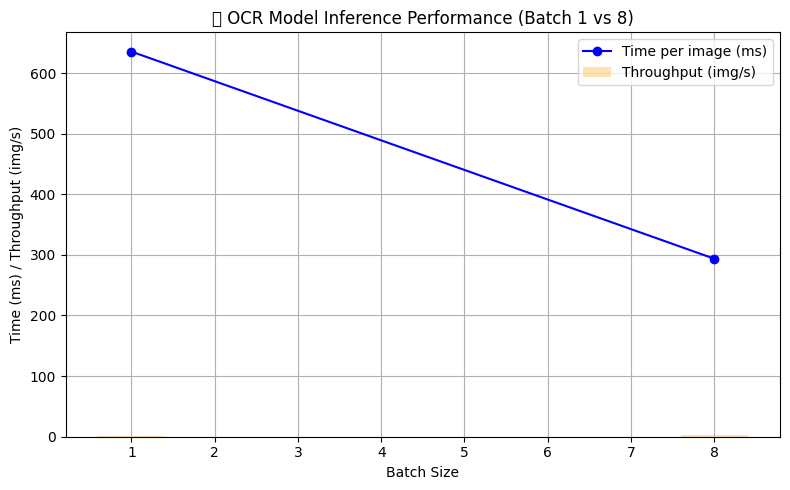

In [2]:
import os, re, time, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# ==== 1️⃣ Cấu hình ====
base_dir = "/home/caokhoa/Documents/hackathon/qbn-hackathon"
mock_file = os.path.join(base_dir, "mock_data_handwriting.txt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# ==== 2️⃣ Đọc file mock ====
pattern = re.compile(r"^(.*\.(?:png|jpg|jpeg|PNG|JPG))\s+(.*)$")
samples = []
with open(mock_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        match = pattern.match(line)
        if match:
            rel_path, label = match.groups()
            img_path = os.path.join(base_dir, rel_path.strip())
            samples.append((img_path, label.strip()))
print(f"✅ Loaded {len(samples)} samples.")

# ==== 3️⃣ Load ảnh hợp lệ ====
images, gts = [], []
for img_path, gt in samples:
    if os.path.exists(img_path):
        images.append(Image.open(img_path).convert("RGB"))
        gts.append(gt)
print(f"✅ Đã load {len(images)} ảnh hợp lệ.")

# ==== 4️⃣ Benchmark batch size 1 và 8 ====
BATCH_SIZES = [1, 8]
instruction = "Write the text representation for this image."
results = []

for batch_size in BATCH_SIZES:
    total_time = 0
    count = 0

    print(f"\n⚙️ Testing batch_size = {batch_size}...")
    for i in tqdm(range(0, len(images), batch_size)):
        batch_imgs = images[i:i+batch_size]

        # Tạo danh sách prompt
        batch_prompts = []
        for _ in batch_imgs:
            messages = [
                {"role": "user", "content": [
                    {"type": "image"},
                    {"type": "text", "text": instruction}
                ]}
            ]
            text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
            batch_prompts.append(text)

        # Tokenize & pad tự động
        inputs = tokenizer(
            batch_imgs,
            batch_prompts,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)

        torch.cuda.synchronize()
        start = time.time()
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=256, temperature=0.2, do_sample=False)
        torch.cuda.synchronize()
        end = time.time()

        total_time += (end - start)
        count += len(batch_imgs)

    avg_time = total_time / count
    throughput = count / total_time
    results.append({
        "Batch Size": batch_size,
        "Total Time (s)": total_time,
        "Avg Time per Image (ms)": avg_time * 1000,
        "Throughput (img/s)": throughput
    })
    print(f"✅ Done batch={batch_size}: {avg_time*1000:.2f} ms/img, {throughput:.2f} img/s")

# ==== 5️⃣ Xuất bảng kết quả ====
df = pd.DataFrame(results)
print("\n📊 Benchmark Summary:")
print(df.to_string(index=False, justify="center"))

# ==== 6️⃣ Biểu đồ ====
plt.figure(figsize=(8,5))
plt.plot(df["Batch Size"], df["Avg Time per Image (ms)"], marker='o', color="blue", label="Time per image (ms)")
plt.bar(df["Batch Size"], df["Throughput (img/s)"], alpha=0.3, color="orange", label="Throughput (img/s)")
plt.xlabel("Batch Size")
plt.ylabel("Time (ms) / Throughput (img/s)")
plt.title("📈 OCR Model Inference Performance (Batch 1 vs 8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import os, re, time, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# ==== 1️⃣ Cấu hình ====
base_dir = "/home/caokhoa/Documents/hackathon/qbn-hackathon"
mock_file = os.path.join(base_dir, "mock_data_handwriting.txt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# ==== 2️⃣ Đọc file mock ====
pattern = re.compile(r"^(.*\.(?:png|jpg|jpeg|PNG|JPG))\s+(.*)$")
samples = []
with open(mock_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        match = pattern.match(line)
        if match:
            rel_path, label = match.groups()
            img_path = os.path.join(base_dir, rel_path.strip())
            samples.append((img_path, label.strip()))
print(f"✅ Loaded {len(samples)} samples.")

# ==== 3️⃣ Load ảnh hợp lệ ====
images, gts = [], []
for img_path, gt in samples:
    if os.path.exists(img_path):
        images.append(Image.open(img_path).convert("RGB"))
        gts.append(gt)
print(f"✅ Đã load {len(images)} ảnh hợp lệ.")

# ==== 4️⃣ Benchmark batch size 1 và 8 ====
BATCH_SIZES = [16, 32]
instruction = "Write the text representation for this image."
results = []

for batch_size in BATCH_SIZES:
    total_time = 0
    count = 0

    print(f"\n⚙️ Testing batch_size = {batch_size}...")
    for i in tqdm(range(0, len(images), batch_size)):
        batch_imgs = images[i:i+batch_size]

        # Tạo danh sách prompt
        batch_prompts = []
        for _ in batch_imgs:
            messages = [
                {"role": "user", "content": [
                    {"type": "image"},
                    {"type": "text", "text": instruction}
                ]}
            ]
            text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
            batch_prompts.append(text)

        # Tokenize & pad tự động
        inputs = tokenizer(
            batch_imgs,
            batch_prompts,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)

        torch.cuda.synchronize()
        start = time.time()
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=256, temperature=0.2, do_sample=False)
        torch.cuda.synchronize()
        end = time.time()

        total_time += (end - start)
        count += len(batch_imgs)

    avg_time = total_time / count
    throughput = count / total_time
    results.append({
        "Batch Size": batch_size,
        "Total Time (s)": total_time,
        "Avg Time per Image (ms)": avg_time * 1000,
        "Throughput (img/s)": throughput
    })
    print(f"✅ Done batch={batch_size}: {avg_time*1000:.2f} ms/img, {throughput:.2f} img/s")

# ==== 5️⃣ Xuất bảng kết quả ====
df = pd.DataFrame(results)
print("\n📊 Benchmark Summary:")
print(df.to_string(index=False, justify="center"))

# ==== 6️⃣ Biểu đồ ====
plt.figure(figsize=(8,5))
plt.plot(df["Batch Size"], df["Avg Time per Image (ms)"], marker='o', color="blue", label="Time per image (ms)")
plt.bar(df["Batch Size"], df["Throughput (img/s)"], alpha=0.3, color="orange", label="Throughput (img/s)")
plt.xlabel("Batch Size")
plt.ylabel("Time (ms) / Throughput (img/s)")
plt.title("📈 OCR Model Inference Performance (Batch 1 vs 8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Loaded 53 samples.
✅ Đã load 53 ảnh hợp lệ.

⚙️ Testing batch_size = 16...


  0%|          | 0/4 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 976.00 MiB. GPU 0 has a total capacity of 3.68 GiB of which 768.00 MiB is free. Including non-PyTorch memory, this process has 2.91 GiB memory in use. Of the allocated memory 2.74 GiB is allocated by PyTorch, and 53.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)